In [1]:
%pip install openai
from openai import OpenAI
import json
import warnings
warnings.filterwarnings('ignore')
import pandas as pd

# OpenAI API and Data Setup

In [3]:
#get the openai api key from config.json file.
with open('config.json') as f:
    data = json.load(f)
    api_key = data['OPENAI_API_KEY']
    f.close()

client = OpenAI(
    api_key=api_key
)

KeyError: 'OPENAI_API_KEY'

: 

In [3]:
#we select the data/true_clean.csv and fake data and fuse them into a single dataframe.

true_df = pd.read_csv('data/true_clean.csv')
fake_df = pd.read_csv('data/fake_clean.csv')
fake_df = fake_df.sample(n=len(true_df), replace=True, random_state=42)
# On ajoute à chaque dataframe la colonne "isFake"
fake_df["isFake"]=True
true_df["isFake"]=False
# we fuse the dataset and shuffle it
df = pd.concat([true_df, fake_df])
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [4]:
df.columns

Index(['title', 'text', 'subject', 'date', 'title_processed', 'text_processed',
       'isFake'],
      dtype='object')

In [4]:
data = df[['text_processed','isFake']]

In [5]:
data.isFake.unique()

array([False,  True])

In [6]:
data.shape

(41642, 2)

In [7]:
data.iloc[0]['text_processed']

'washington reuter north korea ambassador unit nation friday ignor we call cessat weapon test allow talk pyongyang nuclear program say countri would pose threat state long interest infring upon us secretari state rex tillerson earli tell meet un secur council pyongyang nuclear ballist missil program sustain cessat north korea threaten behavior need talk could occur washington pyongyang north korea un ambassador ja song nam make mention tillerson call speech session call desper measur plot we terrifi incred might republ success achiev great histor caus complet state nuclear forc'

In [8]:
data.iloc[0]['isFake']

False

In [9]:
data['isFake'] = data['isFake'].astype(int)

In [10]:
data.iloc[0]['isFake'] #fake is 0 and true is 1

0

In [11]:
#check data for nan values
data.isnull().sum()

text_processed    4
isFake            0
dtype: int64

In [12]:
data=data.dropna()

In [13]:
data

,text_processed,isFake
0,washington reuter north korea ambassador unit ...,0
1,trump offici go next presid unit state support...,1
2,hous repres vote tuesday end fraud within depa...,1
3,shawn helton st centuri wirepresidentelect don...,1
4,reuter republican presidenti candid donald tru...,0
...,...,...
41637,washington reuter incom us administr tough tal...,0
41638,moscow reuter russian foreign minist sergei la...,0
41639,lou dobb rip speaker paul ryan donoth leader d...,1
41640,reuter new jersey man work world trade center ...,0


In [15]:
#return me a json content for openai api fine tune
text=None

def create_jsonl(row):
    return {"messages": [
    {"role": "system", "content": "Predict if this news is false (0) or true (1)."}, 
    {"role": "user", "content": row['text_processed']}, 
    {"role": "assistant", "content": str(row['isFake'])}]
}


create_jsonl(data.iloc[0])

{'messages': [{'role': 'system',
   'content': 'Predict if this news is false (0) or true (1).'},
  {'role': 'user',
   'content': 'washington reuter north korea ambassador unit nation friday ignor we call cessat weapon test allow talk pyongyang nuclear program say countri would pose threat state long interest infring upon us secretari state rex tillerson earli tell meet un secur council pyongyang nuclear ballist missil program sustain cessat north korea threaten behavior need talk could occur washington pyongyang north korea un ambassador ja song nam make mention tillerson call speech session call desper measur plot we terrifi incred might republ success achiev great histor caus complet state nuclear forc'},
  {'role': 'assistant', 'content': '0'}]}

In [18]:

# with the "with" statement, we can ensure that the file will be closed when leaving the block
with open('train.jsonl', 'w') as f:
    for i in range(0, int(len(data)*0.8)):
        json.dump(create_jsonl(data.iloc[i]), f)
        f.write('\n')

with open('valid.jsonl', 'w') as f:
    for i in range(int(len(data)*0.8,len(data) )):
        json.dump(create_jsonl(data.iloc[i]), f)
        f.write('\n')

# OpenAI trained model validation

We send the created data into the openai api and we will be able to use it later on, those are his parameters:
- **Base model**: `GPT-3.5-turbo-1106` (this is the default gpt-3.5 model that we will fine-tune for our usage)
- **epochs**: `1` (the number of epochs it goes though)
- **batch size**: `22`
- **Lr multiplier**: `2` (the learning rate multiplier.)
- **Seed** : `42` 
- **Suffix**: `FakeNewsClassifier` (name of the fine-tuned model)

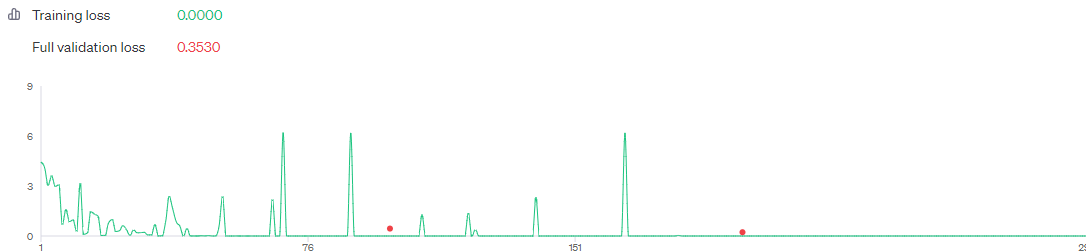

In [43]:
#we load the image ""gpt model image.png"
from IPython.display import Image
Image(filename='gpt model image.png')


In [23]:
#we select the data/true_clean.csv and fake data and fuse them into a single dataframe.

true_df = pd.read_csv('data/true_clean.csv')
fake_df = pd.read_csv('data/fake_clean.csv')
fake_df = fake_df.sample(n=len(true_df), replace=True, random_state=42)
# On ajoute à chaque dataframe la colonne "isFake"
fake_df["isFake"]=True
true_df["isFake"]=False
# we fuse the dataset and shuffle it
df = pd.concat([true_df, fake_df])
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
data = df[['text_processed','isFake']]
data.head()

,text_processed,isFake
0,washington reuter north korea ambassador unit ...,False
1,trump offici go next presid unit state support...,True
2,hous repres vote tuesday end fraud within depa...,True
3,shawn helton st centuri wirepresidentelect don...,True
4,reuter republican presidenti candid donald tru...,False


In [24]:
data['isFake'] = data['isFake'].astype(int)
data.iloc[0]['isFake'] #true news is 0 and fake news is 1

0

In [19]:
def getGPTresponse(text):
    completion = client.chat.completions.create(
      model="ft:gpt-3.5-turbo-1106:personal:fakenewsclassifier:9IZVG4oQ",
      messages=[
        {"role": "system", "content": "Predict if this news is false (0) or true (1)."},
        {"role": "user", "content": text}
      ]
    )
    return completion.choices[0].message.content


getGPTresponse(data.iloc[0]['text_processed'])

'0'

In [21]:
#we used 50 samples to train the model and validate it. as such we can simply run the whole dataset as a validation set.

#we get the data/valid_clean.csv data
valid_df = pd.read_csv('data/valid_clean.csv')
valid_df.head()

,Unnamed: 0,text,isFake,text_processed
0,0,"Daniel Greenfield, a Shillman Journalism Fello...",False,daniel greenfield shillman journal fellow free...
1,1,Google Pinterest Digg Linkedin Reddit Stumbleu...,False,googl pinterest digg linkedin reddit stumbleup...
2,2,U.S. Secretary of State John F. Kerry said Mon...,True,us secretari state john f kerri say monday sto...
3,3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",False,kayde king kaydeek novemb lesson tonight dem l...
4,4,It's primary day in New York and front-runners...,True,primari day new york frontrunn hillari clinton...


In [22]:
valid_df['isFake'] = valid_df['isFake'].astype(int) #true is 0 and false is 1
valid_df.head()

,Unnamed: 0,text,isFake,text_processed
0,0,"Daniel Greenfield, a Shillman Journalism Fello...",0,daniel greenfield shillman journal fellow free...
1,1,Google Pinterest Digg Linkedin Reddit Stumbleu...,0,googl pinterest digg linkedin reddit stumbleup...
2,2,U.S. Secretary of State John F. Kerry said Mon...,1,us secretari state john f kerri say monday sto...
3,3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",0,kayde king kaydeek novemb lesson tonight dem l...
4,4,It's primary day in New York and front-runners...,1,primari day new york frontrunn hillari clinton...


In [28]:
# does it contain nan values
valid_df.isnull().sum()
#drop nan values
valid_df=valid_df.dropna()

In [39]:
# we take the values after the 100 into a new dataframe
valid_df_sample= valid_df.iloc[100:1000]

In [40]:
valid_df_sample.loc[:, 'predicted_isFake'] = valid_df_sample['text_processed'].progress_apply(lambda x: int(getGPTresponse(x)))


100%|██████████| 900/900 [08:44<00:00,  1.71it/s]


In [42]:
#we check the accuracy of the model
from sklearn.metrics import accuracy_score
acc= accuracy_score(valid_df_sample['isFake'], valid_df_sample['predicted_isFake'])

print(f'accuracy: {acc:.2f}')

accuracy: 0.35


## Utilisation  de vr AI

In [ ]:
vrAI = 0
if acc > 0.90:
    vrAI = 'Fx'
elif  0.70<acc<=0.90:
    vrAI = 'F'
elif  0.50<acc<=0.70:
    vrAI = 'E'
elif  0.30<acc<=0.50:
    vrAI = 'D'
elif  0.15<acc<=0.30:
    vrAI = 'C'
elif  0.05<acc<=0.15:
    vrAI = 'B'
else:
    vrAI = 'A'